In [ ]:
# Clear namespace
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

Import libraries

In [4]:
#Import libraries before starting
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from collections import Counter


**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Image Classification

In this project, we aim to classify images of handwritten digits. 

The data set is provided in the file `dataset_1.txt` and contains 8x8 gray-scale images of hand-written digits, flattened to a 64-length vector. The last column contains the digit. For simplicity, we have only included digits 0, 1 and 3. 

We want to build a model that can be given the image of a hand-written digit and correctly classify this digit as 0, 1 or 3.

### Step 1: Read in the data and visualize

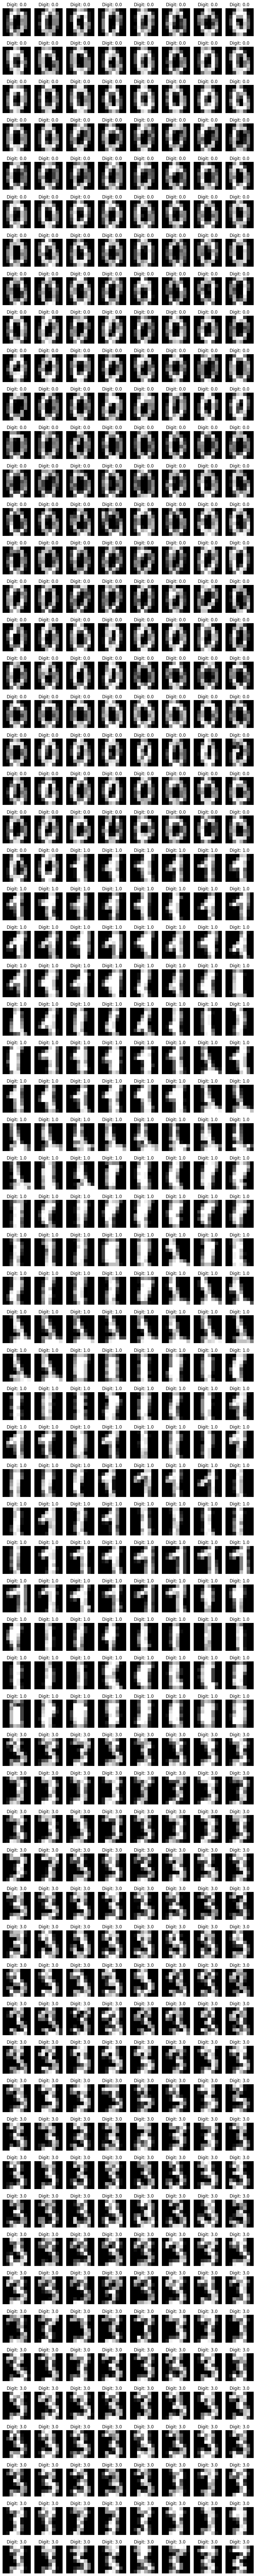

In [10]:
#Code here
#data= pd.read_csv('dataset_1.txt').to_numpy()
#digit = data[:, 64]
data = pd.read_csv('dataset_1.txt', header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

fig, axes = plt.subplots(nrows=67, ncols=8, figsize=(10, 100))

for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit: {y[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Part 1(a).  Reduce the data

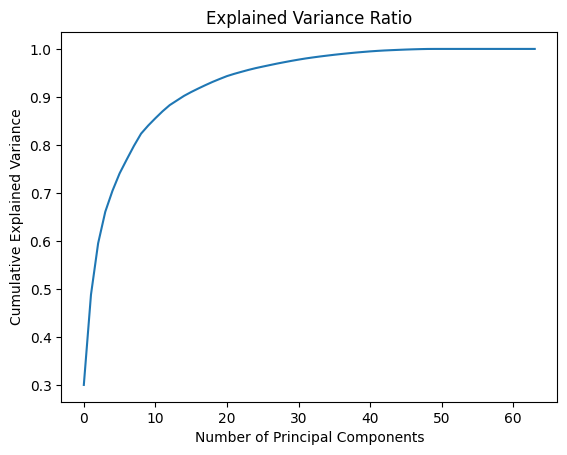

In [11]:
#Code here
covariance_matrix = np.cov(X.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.show()

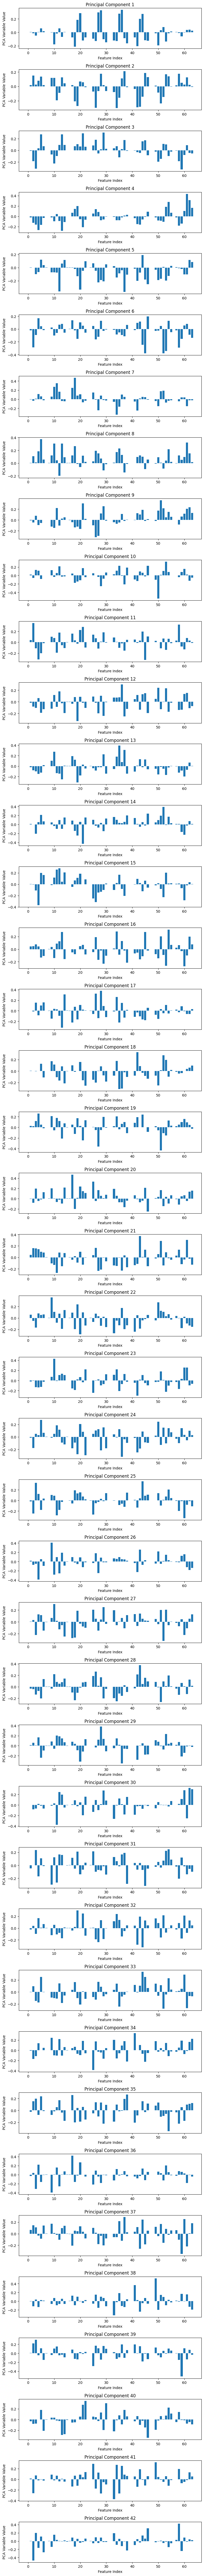

In [12]:
n_components =42
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
fig, axes = plt.subplots(nrows=n_components, ncols=1, figsize=(8, 100))

for i, ax in enumerate(axes):
    ax.bar(range(len(pca.components_[i])), pca.components_[i])
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('PCA Variable Value')
    ax.set_title(f'Principal Component {i+1}')

plt.tight_layout()
plt.show()

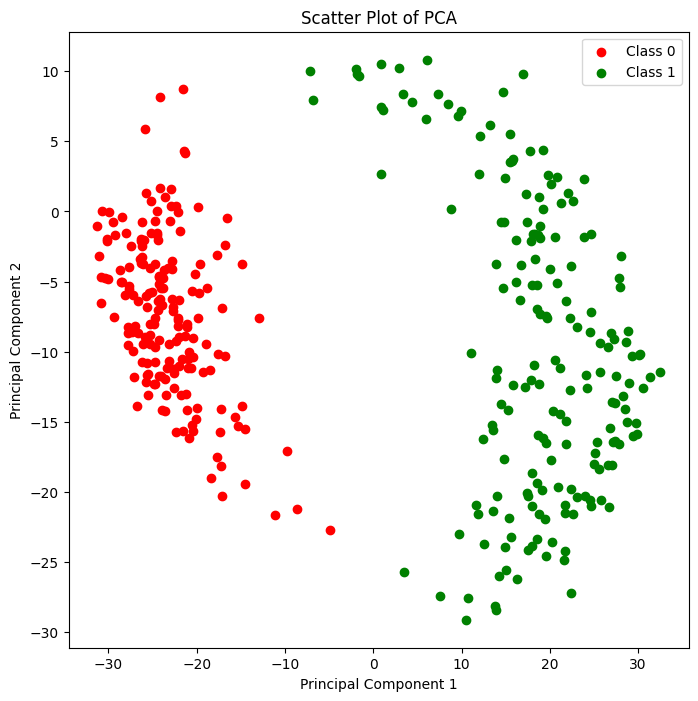

In [27]:
colors = ['r', 'g'] 
labels = ['Class 0', 'Class 1']

fig, ax = plt.subplots(figsize=(8, 8))
for i, label in enumerate(labels):
    class_indices = np.where(y == i)
    class_data = X_pca[class_indices]
    ax.scatter(class_data[:, 0],
               class_data[:, 1],
               color=colors[i],
               label=label)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Scatter Plot of PCA')
ax.legend()
plt.show()


In [29]:
print(y.shape)
print(X_pca.shape)

(543,)
(543, 42)



Let's now try reducing the number of dimensions in the data using PCA. 

In [31]:
#Code here
data = pd.read_csv('dataset_1.txt', header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
n_components = 10
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
print("Shape of X_pca:", X_pca.shape)

Shape of X_pca: (543, 10)


### Part 1(b). Build a classifier


**Solution:**

In [32]:
#Code here
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
clf_01 = LogisticRegression()
clf_01.fit(X_train, (y_train == 0) | (y_train == 1))
y_pred_01 = clf_01.predict(X_test)
accuracy_01 = accuracy_score((y_test == 0) | (y_test == 1), y_pred_01)
print("Accuracy (0 vs 1):", accuracy_01)
clf_03 = LogisticRegression()
clf_03.fit(X_train, (y_train == 0) | (y_train == 3))
y_pred_03 = clf_03.predict(X_test)
accuracy_03 = accuracy_score((y_test == 0) | (y_test == 3), y_pred_03)
print("Accuracy (0 vs 3):", accuracy_03)
clf_13 = LogisticRegression()
clf_13.fit(X_train, (y_train == 1) | (y_train == 3))
y_pred_13 = clf_13.predict(X_test)
accuracy_13 = accuracy_score((y_test == 1) | (y_test == 3), y_pred_13)
print("Accuracy (1 vs 3):", accuracy_13)

Accuracy (0 vs 1): 0.9908256880733946
Accuracy (0 vs 3): 1.0
Accuracy (1 vs 3): 1.0


### Part 1(c). Build a better one

**Solution:**

Processing: 100%|███████████████████████████████| 42/42 [00:07<00:00,  5.55it/s]


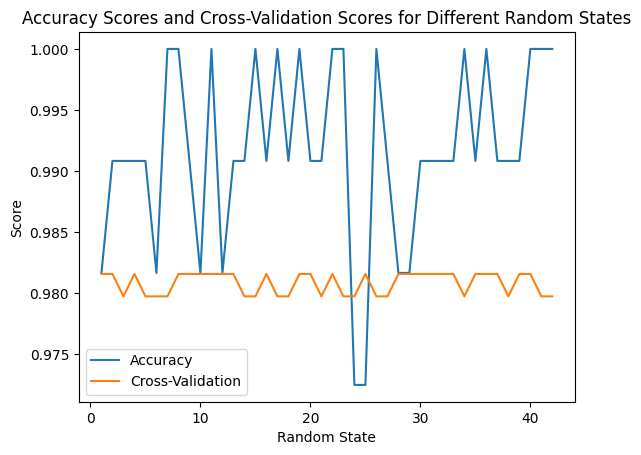

In [46]:
#Code here
# Sklearn uses different class and solvers to classify as mentioned in its documentations.
# Using Cross Validation for finding optimal random states:
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
random_states = range(1, 43)


accuracy_scores = []
cv_scores = []



for random_state in tqdm(random_states, desc='Processing'):

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=random_state)

    clf_multiclass = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000)
    clf_multiclass.fit(X_train, y_train)

    y_pred_multiclass = clf_multiclass.predict(X_test)

    accuracy_multiclass = accuracy_score(y_test, y_pred_multiclass)
    accuracy_scores.append(accuracy_multiclass)

    scores = cross_val_score(clf_multiclass, X_pca, y, cv=5)
    cv_scores.append(np.mean(scores))

plt.plot(random_states, accuracy_scores, label='Accuracy')
plt.plot(random_states, cv_scores, label='Cross-Validation')
plt.xlabel('Random State')
plt.ylabel('Score')
plt.title('Accuracy Scores and Cross-Validation Scores for Different Random States')
plt.legend()
plt.show()